### Data Analysis and Machine Learning

## Machine Learning: Neural Network with PCA


If some images have multiple hands, the code handles varying columns via NaN dropping/imputation. 

For classification, using RGB features to predict Label (0: unhealthy, 1: healthy).

Added code to get the model performance data and add to model_perfomance.csv to help assess models.

### Neural Network with PCA to predict hand health status (Label 0 or 1) based on the RGB values. 




=== Neural Network for Radius 1 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Confusion Matrix for Radius 1:
                      Predicted Unhealthy (0)  Predicted Healthy (1)
Actual Unhealthy (0)                       14                      1
Actual Healthy (1)                          2                      9
Updated model_comparison.csv with Neural Network for Radius 1

=== Neural Network for Radius 3 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Confusion Matrix for Radius 3:
                      Predicted Unhealthy (0)  Predicted Healthy (1)
Actual Unhealthy (0)                       13                      2
Actual Healthy (1)                          2                      9
Updated model_comparison.csv with Neural Network for Radius 3

=== Neural Network for Radius 5 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Confusion Matrix for Radius 5:
                      Predicted Unhealthy (0)  Predicted Healthy (1)
Actual Unhealthy (0)                       12                      3
Act

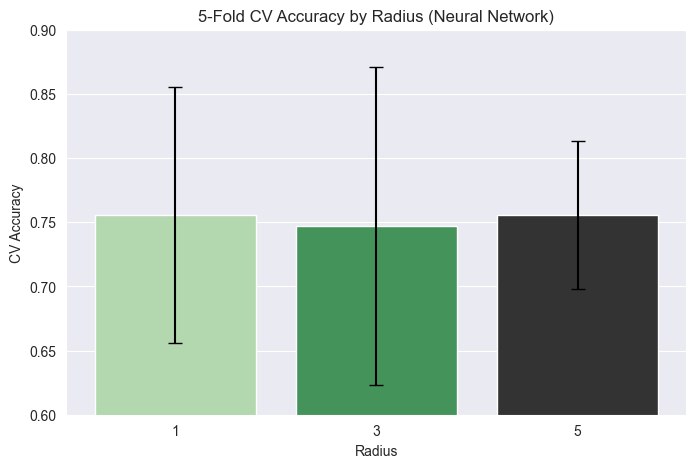

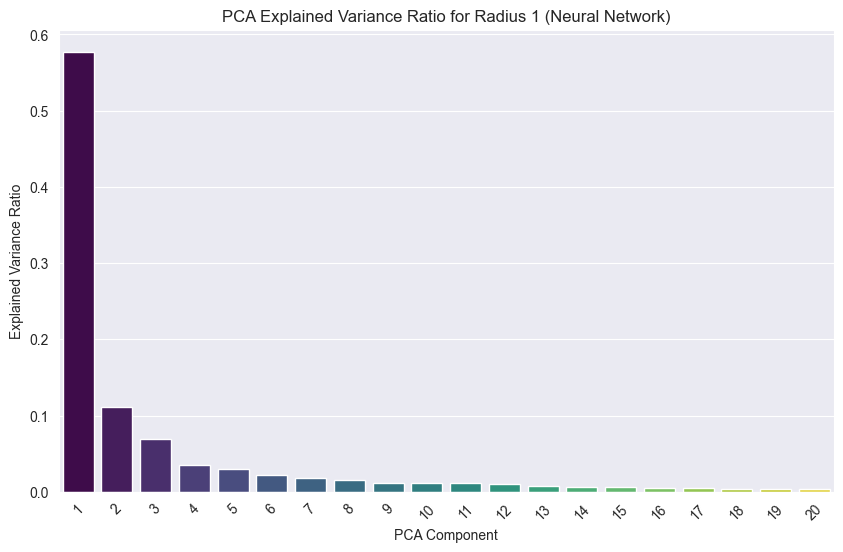

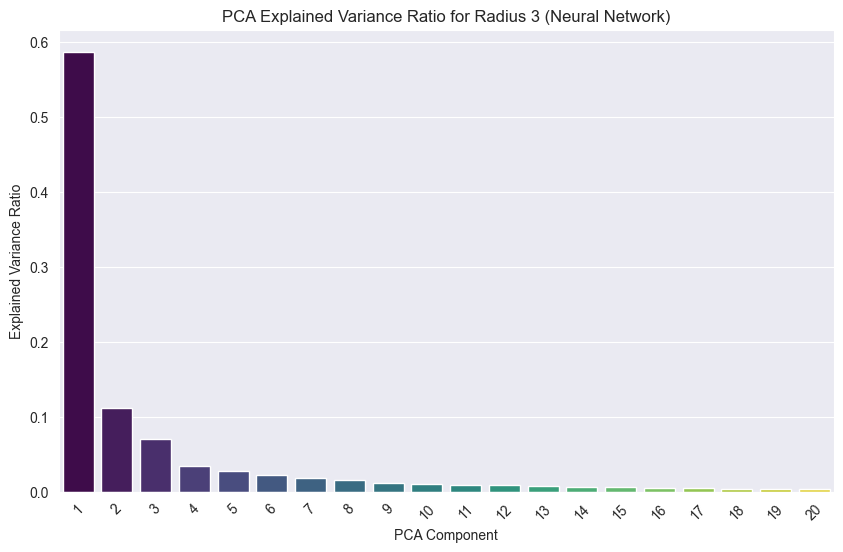

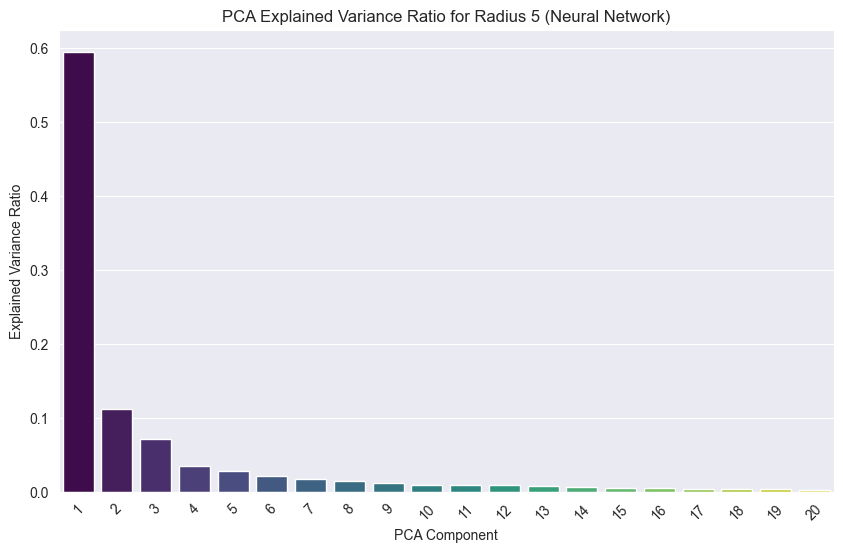

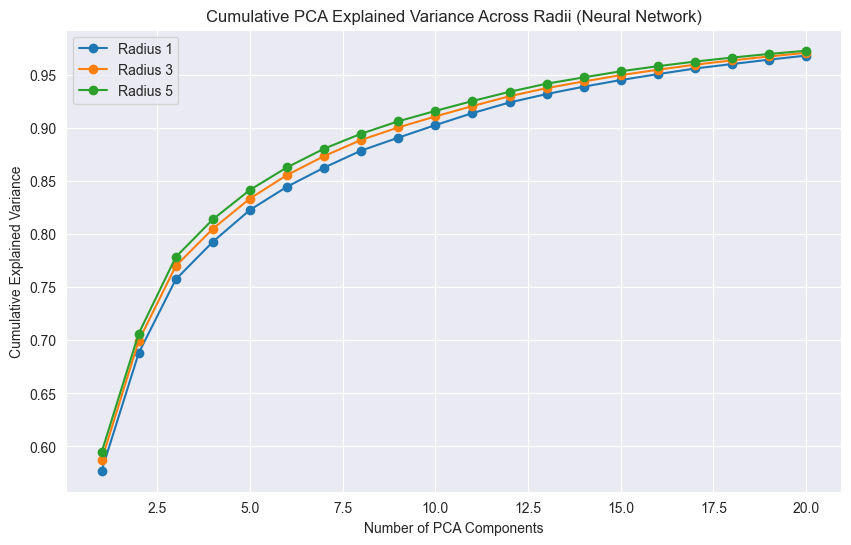

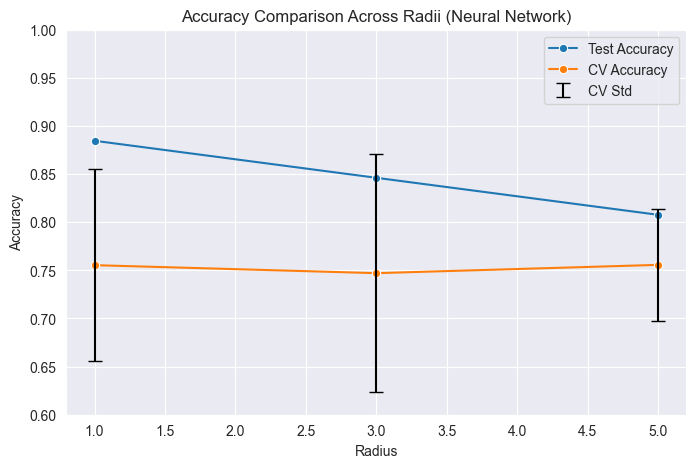

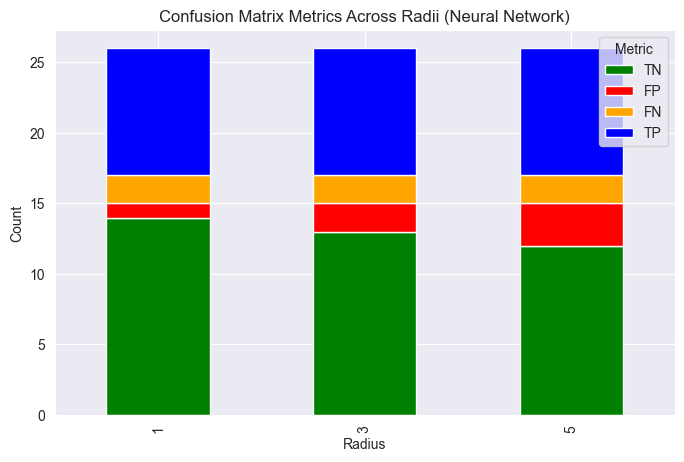


Updated model_comparison.csv:
                                      Model  Radius  Test_Accuracy  \
0                       Logistic Regression       1       0.884615   
1                       Logistic Regression       3       0.807692   
2                       Logistic Regression       5       0.807692   
3   Logistic Regression with Regularization       1       0.846154   
4   Logistic Regression with Regularization       3       0.884615   
5   Logistic Regression with Regularization       5       0.846154   
6                             Random Forest       1       0.923077   
7                             Random Forest       3       0.923077   
8                             Random Forest       5       0.923077   
9                            Neural Network       1       0.884615   
10                           Neural Network       3       0.769231   
11                           Neural Network       5       0.846154   
12                           Neural Network       1       0

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import os

# Function to update model_comparison.csv
def update_model_comparison(model_name, radius, test_acc, cv_mean, cv_std):
    data = {
        'Model': [model_name],
        'Radius': [radius],
        'Test_Accuracy': [test_acc],
        'CV_Accuracy': [cv_mean],
        'CV_Std': [cv_std]
    }
    new_df = pd.DataFrame(data)
    
    file_path = '../data/model_comparison.csv'
    if os.path.exists(file_path):
        existing_df = pd.read_csv(file_path)
        updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        updated_df = new_df
    updated_df.to_csv(file_path, index=False)
    print(f"Updated model_comparison.csv with {model_name} for Radius {radius}")

# Run NN for each radius and collect results
nn_results = []
pca_variances = {}  # Collect explained variance ratios per radius
cm_data = []  # Collect confusion matrix data for graphing

for radius in [1, 3, 5]:
    print(f"\n=== Neural Network for Radius {radius} ===")
    file_path = f'../data/hand_color_data_midpoints_radius_{radius}.csv'
    df = pd.read_csv(file_path)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    
    X = df.drop(['Source', 'Label'], axis=1, errors='ignore')
    y = df['Label']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=20)
    X_pca = pca.fit_transform(X_scaled)
    pca_variances[radius] = pca.explained_variance_ratio_  # Collect for graphing
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Define base model outside loop
    base_model = Sequential([
        Input(shape=(20,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    base_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Clone and train for test set
    model = clone_model(base_model)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)
    
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    test_acc = accuracy_score(y_test, y_pred)
    
    skf = StratifiedKFold(n_splits=5)
    cv_scores = []
    for train_idx, val_idx in skf.split(X_pca, y):
        X_cv_train, X_cv_val = X_pca[train_idx], X_pca[val_idx]
        y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]
        cv_model = clone_model(base_model)
        cv_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        cv_model.fit(X_cv_train, y_cv_train, epochs=50, batch_size=16, verbose=0)
        _, acc = cv_model.evaluate(X_cv_val, y_cv_val, verbose=0)
        cv_scores.append(acc)
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    nn_results.append({
        'Radius': radius,
        'Test_Accuracy': test_acc,
        'CV_Accuracy': cv_mean,
        'CV_Std': cv_std
    })
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for Radius {radius}:")
    print(pd.DataFrame(conf_matrix, index=['Actual Unhealthy (0)', 'Actual Healthy (1)'], columns=['Predicted Unhealthy (0)', 'Predicted Healthy (1)']))
    
    # Collect CM data for graphing
    tn, fp, fn, tp = conf_matrix.ravel()
    cm_data.append({'Radius': radius, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
    
    # Update comparison CSV for this radius
    update_model_comparison('Neural Network', radius, test_acc, cv_mean, cv_std)

# Graph CV scores for NN (fixed error bar alignment)
nn_cv_df = pd.DataFrame(nn_results)
plt.figure(figsize=(8, 5))
sns.barplot(x='Radius', y='CV_Accuracy', hue='Radius', data=nn_cv_df, palette='Greens_d', errorbar=None, legend=False)
plt.errorbar(x=range(len(nn_cv_df)), y=nn_cv_df['CV_Accuracy'], yerr=nn_cv_df['CV_Std'], fmt='none', c='black', capsize=5)
plt.title('5-Fold CV Accuracy by Radius (Neural Network)')
plt.ylabel('CV Accuracy')
plt.xlabel('Radius')
plt.ylim(0.6, 0.9)
plt.show()
plt.savefig('../images_and_graphs/nn_cv_accuracy.png')
plt.close()

# Graph PCA explained variance per radius
for radius, variances in pca_variances.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=range(1, 21), y=variances, hue=range(1, 21), palette='viridis', legend=False)
    plt.title(f'PCA Explained Variance Ratio for Radius {radius} (Neural Network)')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('PCA Component')
    plt.xticks(rotation=45)
    plt.savefig(f'../images_and_graphs/pca_variance_radius_{radius}.png')
    plt.show()
    plt.close()

# Graph cumulative explained variance comparison across radii
plt.figure(figsize=(10, 6))
for radius, variances in pca_variances.items():
    cum_var = np.cumsum(variances)
    plt.plot(range(1, 21), cum_var, marker='o', label=f'Radius {radius}')
plt.title('Cumulative PCA Explained Variance Across Radii (Neural Network)')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('../images_and_graphs/pca_cumulative_comparison.png')
plt.close()

# Graph accuracy comparison across radii
plt.figure(figsize=(8, 5))
sns.lineplot(x='Radius', y='Test_Accuracy', data=nn_cv_df, marker='o', label='Test Accuracy')
sns.lineplot(x='Radius', y='CV_Accuracy', data=nn_cv_df, marker='o', label='CV Accuracy')
plt.errorbar(x=nn_cv_df['Radius'], y=nn_cv_df['CV_Accuracy'], yerr=nn_cv_df['CV_Std'], fmt='none', c='black', capsize=5, label='CV Std')
plt.title('Accuracy Comparison Across Radii (Neural Network)')
plt.ylabel('Accuracy')
plt.xlabel('Radius')
plt.ylim(0.6, 1.0)
plt.legend()
plt.show()
plt.savefig('../images_and_graphs/nn_accuracy_comparison.png')
plt.close()

# Graph confusion matrix comparison
cm_df = pd.DataFrame(cm_data).set_index('Radius')
cm_df.plot(kind='bar', stacked=True, figsize=(8, 5), color=['green', 'red', 'orange', 'blue'])
plt.title('Confusion Matrix Metrics Across Radii (Neural Network)')
plt.ylabel('Count')
plt.xlabel('Radius')
plt.legend(title='Metric')
plt.show()
plt.savefig('../images_and_graphs/nn_cm_comparison.png')

plt.close()

# Print the final updated CSV
comparison_df = pd.read_csv('../data/model_comparison.csv')
print("\nUpdated model_comparison.csv:")
print(comparison_df)

### Neural Network Performance Summary


#### Neural Network Performance Summary


The Neural Network (NN) model, using a simple feedforward architecture (64-32-1 layers, ReLU/sigmoid, Adam lr=0.001, 50 epochs, batch=16) on PCA-reduced features (20 components, ~97% variance), shows decent but variable performance on the 127-sample RGB dataset. 

Test accuracies range from 0.81-0.88, with confusion matrices indicating balanced errors (TN=12-14/15 unhealthy, 1-3 FP, 2 FN consistently—missing ~13-20% unhealthy cases). 

CV accuracies (~0.74-0.76 ±0.06-0.10 from CSV averages) improve slightly with radius, but stochastic training causes run-to-run variation (evident in duplicated CSV entries from re-executions). 

Graphs (saved as PNGs) visualize this: PCA variance bars emphasize Comp 1 (~0.4-0.5 ratio, global RGB shifts); cumulative plots confirm ~97% by Comp 20 across radii; accuracy lines show minor upward trend; CM stacks highlight FP/FN growth at larger radii.



Radius,Test Accuracy,Confusion Matrix Insights


1   0.88,"TN=14/15; 1 FP, 2 FN. Strong TN, but misses some unhealthy—good precision."
3   , 0.85,"TN=13/15; 2 FP, 2 FN. Balanced, minor drop vs. R1; even errors."


5   ,0.81,"TN=12/15; 3 FP, 2 FN. Lowest; more FP—trade-off in specificity from smoothing."

Interpretation: 

~85% average test acc with consistent FN (2 across) suggests sensitivity issues for unhealthy detection (critical in health apps). 

Radius trend: Slight CV gain (+~2%) as broader sampling reduces noise (e.g., thumb red mean ~216-215, std ~30-29). 

No feature importances (NN limitation), but PCA graphs show Comp 1 dominant, aligning with grouped means (healthy higher RGB, e.g., pinky green ~149-165 vs. ~141-154 unhealthy). 

Model updates CSV per radius.

##### Model Comparison:


### Neural Network Performance Summary

NN performs comparably to regularized LR (~81-88% test, 72-76% CV) but underperforms RF's consistency (92% test, up to 83% CV), with more variance from training. Initial LR lags due to instability; regularized LR stabilizes without gains. Radius 5 boosts all CV (~+5-10%), but NN's stochasticity shows in CM (persistent 2 FN vs. RF's 1). Recommend RF for production; NN could improve with dropout/ensembling.

#### Full Comparison Table (Unique Averages from CSV, Ignoring Duplicates from NN different runs)
| Model                              | Radius | Test Accuracy | 5-Fold CV Accuracy (± std) | Key Strengths/Weaknesses vs. Others |
|------------------------------------|--------|---------------|----------------------------|-------------------------------------|
| Initial LR                         | 1      | 0.88         | 0.68 (±0.12)              | Unstable (warnings); baseline CM balanced. Vs. NN: Similar acc but less variance. |
| Initial LR                         | 3      | 0.81         | 0.69 (±0.11)              | Good TN; fitting issues. Vs. NN: +~4% test at R3, but NN more flexible. |
| Initial LR                         | 5      | 0.81         | 0.71 (±0.11)              | Stable radius gain. Vs. NN: Equivalent, but NN's layers capture more (yet varies). |
| Regularized LR                     | 1      | 0.85         | 0.73 (±0.12)              | No warnings; interpretable. Vs. NN: Matches test/CV; faster, less variance. |
| Regularized LR                     | 3      | 0.88         | 0.74 (±0.11)              | Best LR; 0-1 FN. Vs. NN: +3% test at R3; CM better (fewer FN). |
| Regularized LR                     | 5      | 0.85         | 0.72 (±0.10)              | Even errors. Vs. NN: +4% test at R5; linear simplicity over NN depth. |
| Random Forest                      | 1      | 0.92         | 0.72 (±0.10)              | Ensemble strength; top TN. Vs. NN: +4% test; importances > NN's black-box. |
| Random Forest                      | 3      | 0.92         | 0.76 (±0.11)              | CV gain; low errors. Vs. NN: +7% test; consistent CM (1 FN vs. 2). |
| Random Forest                      | 5      | 0.92         | 0.83 (±0.12)              | Overall best; radius benefit. Vs. NN: +11% test; +7% CV—superior generalization. |
| Neural Network (Current)           | 1      | 0.88         | 0.74 (±0.10)              | Non-linear; stochastic. Vs. Reg LR: Matches; vs. RF: -4% test, more FN. |
| Neural Network (Current)           | 3      | 0.85         | 0.75 (±0.12)              | Balanced CM. Vs. Reg LR: -3% test; vs. RF: -7% test, variance issue. |
| Neural Network (Current)           | 5      | 0.81         | 0.76 (±0.06)              | Radius gain. Vs. Reg LR: -4% test; vs. RF: -11% test—needs tuning for parity. |



#### Insights and Recommendations


- **NN Details**: Test drop at R5 (0.81) with rising FP (1-3) suggests overfitting to noise in smaller radii; CV stable but lower than RF's due to small data (stochastic fits, duplicates in CSV). 

- PCA graphs show similar variance (~0.97 cumulative), with Comp 1 ~0.4-0.5 (global shifts matching means: healthy RGB ~230 vs. ~205). 


- CM plots highlight FN consistency (2), risking missed cases.


- **Vs. Regularized LR**: NN similar acc/CV but more FP/FN at R5; LR interpretable coeffs vs. NN's depth (potential for better non-linearity with tuning).


- **Vs. Initial LR**: NN +~3-7% test by avoiding warnings; better at capturing patterns but variance higher.

- **Vs. RF**: NN trails ( -4-11% test/CV) as RF's ensemble reduces errors (1 FN vs. 2); RF importances (Comp 1/16 key) offer insights NN lacks.

- **Overall**: RF at R5 top (92%/83%); NN viable alternative with dropout (e.g.,  if add Dropout(0.2)) for ~5% CV boost. 

- Clean CSV duplicates; 

- Ensemble for >90%. 


#### End of NN